In [1]:
from pathlib import Path
from scipy.interpolate import griddata
from ssmlearnpy import SSMLearn
from ssmlearnpy.utils.plots import Plot
import matplotlib.pyplot as plt
import numpy as np

## Pre-processing

### Load data

In [ ]:
path = Path("/Users/njo20/Documents/ERCOFTAC/ssm-model-reduction/data/100/beta_1_35.npy")
in_data = np.load(path)[0, ...]
print(f"On-load: {in_data.shape}")  # time, x * y * (u + v)

data = np.split(in_data, 2, axis=-1)
data = np.stack(data, axis=-1)
print(f"Step 1: {data.shape}")  # time, x * y, (u, v)

data = data.transpose(0, 2, 1)
data = data.reshape((data.shape[0], 2, 131, 100))
data = data.transpose(0, 2, 3, 1)
print(f"Step 2: {data.shape}")

On-load: (3333, 26200)
Step 1: (3333, 13100, 2)
Step 2: (3333, 131, 100, 2)


### Load coordinates

In [3]:
path = Path("/Users/njo20/Documents/ERCOFTAC/ssm-model-reduction/data/coordinates.npy")
coords = np.load(path)
print(coords.shape)

(131, 100, 2)


### Plot velocity field

In [4]:
# Extract pairwise coordinates
x, y = coords[..., 0].flatten(), coords[..., 1].flatten()

In [5]:
# Create a regular mesh
ngridx, ngridy = 131, 100
xi = np.linspace(np.min(x), np.max(x), ngridx)
yi = np.linspace(np.min(y), np.max(y), ngridy)

In [24]:
# Interpolate onto a regular mesh
path = Path("/Users/njo20/Documents/ERCOFTAC/ssm-model-reduction/data/100/beta_1_35_reg.npy")

try:
    reg_data = np.load(path)
    np.save(path, reg_data)
except:
    reg_data = np.zeros((data.shape[0], ngridy, ngridx, 2))
    for i, time_slice in enumerate(data):
        for j in range(2):
            reg_data[i, ..., j] = griddata((x, y), time_slice[..., j].flatten(), (xi[np.newaxis, :], yi[:, np.newaxis]), method='linear')

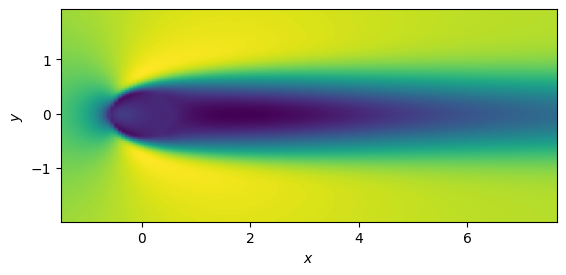

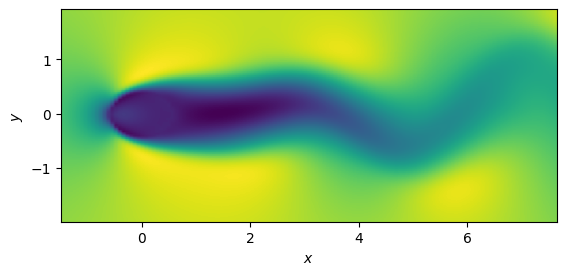

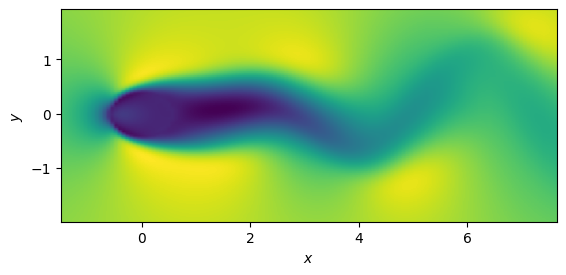

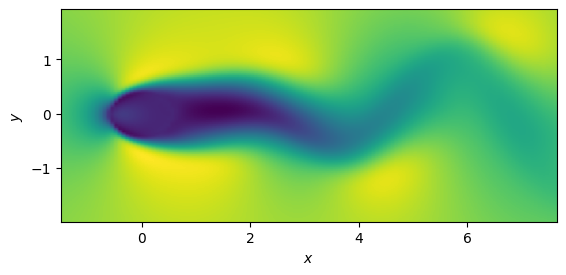

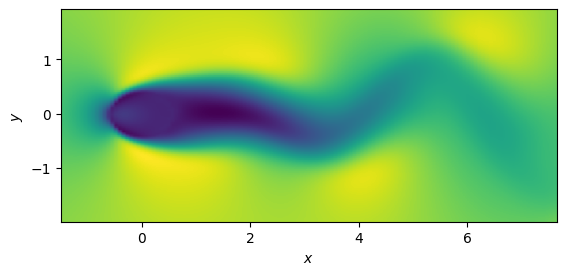

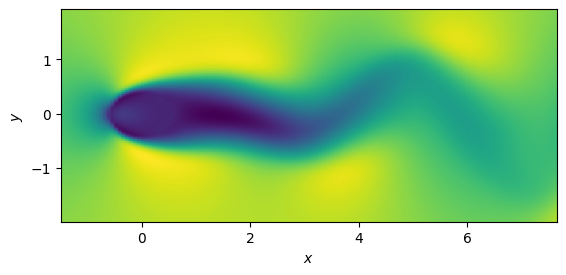

In [25]:
for time_slice in reg_data[::len(reg_data) // 5]:
    plt.imshow(time_slice[..., 0], extent=[np.min(x), np.max(x), np.min(y), np.max(y)], origin="lower")
    plt.xlabel(r"$x$")
    plt.ylabel(r"$y$")
    plt.show()

### Train-Test splitting

In [26]:
index = int(0.8 * in_data.shape[0])
train, test = in_data[:index], in_data[index:]
print(train.shape)

(2666, 26200)


### Truncate time until convergence

In [27]:
pass

In [28]:
print(train.shape)

(2666, 26200)


In [29]:
train -= np.mean(train[200:, ...], axis=0)
train = train[200:]

In [42]:
train = train[200:]

In [43]:
# traj = 1
ssm = SSMLearn(
    t=[np.linspace(0, 1, train.shape[0])],  # shape: traj, time
    x=[train.transpose(1, 0)],  # shape: traj, dim, time
    # derive_embdedding=False,  # <- typo
    ssm_dim=2,
    dynamics_type="flow",
)

INFO   2025-04-16 09:11:30 main Getting coordinates embeddings


In [44]:
ssm.get_reduced_coordinates("linearchart")
ssm.get_parametrization()

INFO   2025-04-16 09:11:44 ridge Transforming data
INFO   2025-04-16 09:11:44 ridge Skipping CV on ridge regression
INFO   2025-04-16 09:11:44 ridge Fitting regression model


In [45]:
plotter = Plot(
    label_observables="x",
    label_reduced_coordinates="eta",
)

In [46]:
fig = plotter.make_plot(ssm, data_name="reduced_coordinates", idx_coordinates=[1, 2])
fig.show()

In [47]:
fig = plotter.make_plot(ssm, data_name="observables", idx_trajectories=[0], idx_coordinates=[0, 1, 2],
                        with_predictions=False, add_surface=True)
fig.show()